In [1]:
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pandas as pd

In [8]:
import os
print(os.getcwd())


/workspace


In [11]:
# Wczytanie danych
df = pd.read_csv("project_Data_Anal/tennis/dataset/tennis_data_2001_2025_FIXED.csv", low_memory=False)

# Konwersja daty
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Usunięcie roku 2020
df = df[df['Date'].dt.year != 2020]

# Wybór istotnych kolumn i usunięcie braków
df = df[['Winner', 'Loser', 'Surface']].dropna()

# Tworzenie mapy graczy do ID
unique_players = pd.unique(df[['Winner', 'Loser']].values.ravel())
player_to_id = {player: i+1 for i, player in enumerate(unique_players)}
id_to_player = {v: k for k, v in player_to_id.items()}

# Zamiana nazw graczy na ID
df['p1'] = df['Winner'].map(player_to_id)
df['p2'] = df['Loser'].map(player_to_id)
df['y'] = 1  # p1 to zawsze zwycięzca

# Finalny DataFrame
stan_df = df[['p1', 'p2', 'y', 'Surface']].copy()
stan_df['WinnerName'] = df['Winner']
stan_df['LoserName'] = df['Loser']

10:31:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:44:02 - cmdstanpy - INFO - CmdStan done processing.
11:44:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_elo.stan', line 16, column 2 to column 27)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_elo.stan', line 16, column 2 to column 27)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_elo.stan', line 16, column 2 to column 27)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_elo.stan', line 16, column 2 to column 27)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_elo.stan', line 16, column 2 to column 27)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_elo.stan', line 16, column 2 to column 27)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_elo.stan', line 16, column 2 to column 27)
	Exception: normal_lp

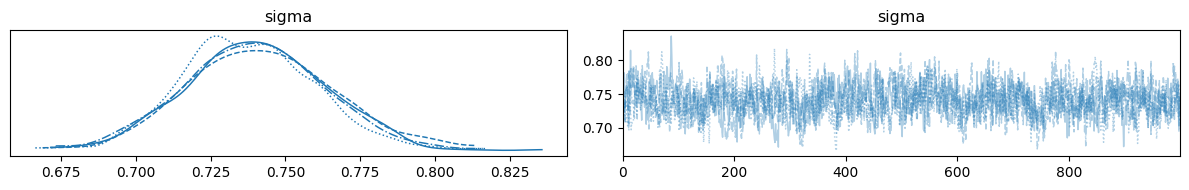

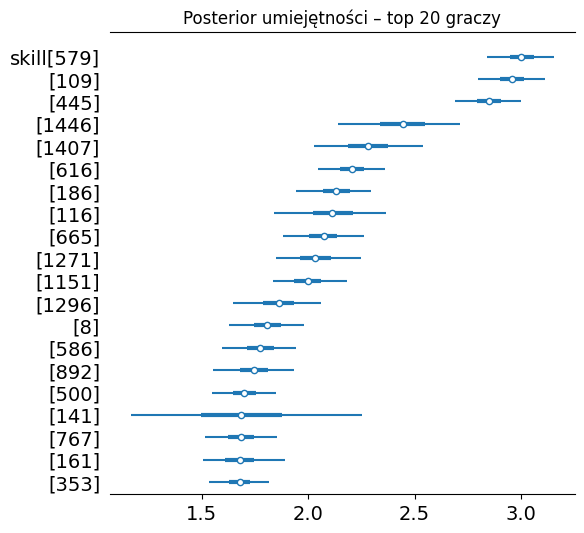

In [13]:
model = CmdStanModel(stan_file='project_Data_Anal/tennis/model_elo.stan')
#model_2 = CmdStanModel(stan_file='lab6/code_2.stan')

stan_data_all = {
    'N': len(stan_df),
    'K': len(player_to_id),
    'p1': stan_df['p1'].tolist(),
    'p2': stan_df['p2'].tolist(),
    'y': stan_df['y'].tolist()
}

fit = model.sample(data=stan_data_all, chains=4, iter_sampling=1000, iter_warmup=500, seed=123)

# Załaduj dane posterior do ArviZ
idata = az.from_cmdstanpy(posterior=fit)

# Wykres trace i gęstości dla sigma
az.plot_trace(idata, var_names=["sigma"])
plt.tight_layout()
plt.show()

# Wykres posterior skill (np. top 20 graczy)
skills = idata.posterior["skill"]
mean_skills = skills.mean(dim=["chain", "draw"]).values
top_indices = mean_skills.argsort()[::-1][:20]

az.plot_forest(idata, var_names=["skill"], coords={"skill_dim_0": top_indices}, combined=True)
plt.title("Posterior umiejętności – top 20 graczy")
plt.show()